In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import glob
# Configurations
IMAGE_PATH = '2D_Sliced_Images/'
MASK_PATH = '2D_Sliced_Masks/'
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 4
EPOCHS = 5
NUM_CLASSES = 3
n_classes=3 #Number of classes for segmentation


In [2]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(r"D:\python\Hapetic2\2D_Sliced_Images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0) 
        img = cv2.resize(img, (128, 128))  # Resize here      
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(r"D:\python\Hapetic2\2D_Sliced_Masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0) 
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)  # Use nearest for masks      
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [3]:
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)

Training images shape: (4416, 128, 128)
Training masks shape: (4416, 128, 128)


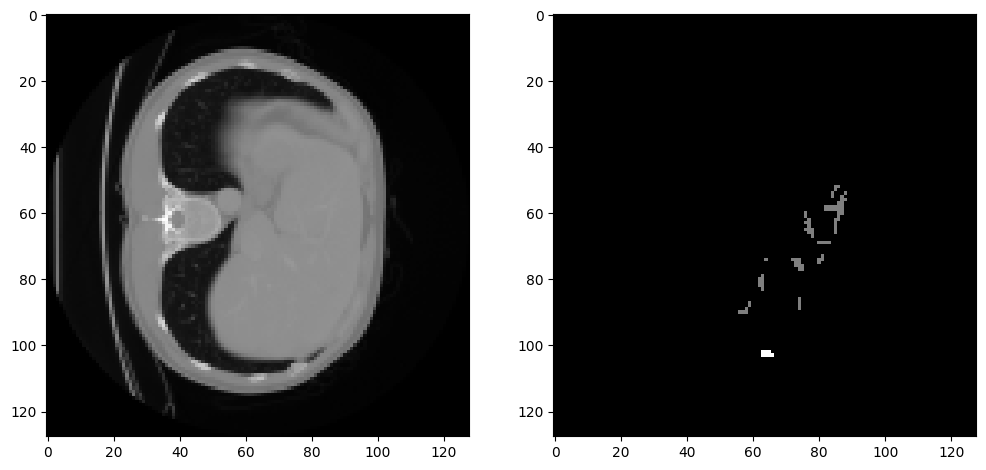

In [4]:
image_number = random.randint(0, len(train_images) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[image_number], cmap='gray')
plt.show()

In [6]:
# Normalize images to the range [0, 1]
train_images = train_images / 128.0
train_masks = np.clip(train_masks, 0, NUM_CLASSES - 1)  # Ensure mask values are within valid range

In [7]:
# Perform one-hot encoding for masks
train_masks = to_categorical(train_masks, num_classes=NUM_CLASSES)

# Print shapes to verify normalization and encoding
print("Normalized and one-hot encoded shapes:")
print("Images shape:", train_images.shape)
print("Masks shape:", train_masks.shape)

Normalized and one-hot encoded shapes:
Images shape: (4416, 128, 128)
Masks shape: (4416, 128, 128, 3)


In [8]:
# First split into 80% train+validation and 20% test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# Further split the 80% train+validation into 75% train and 25% validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 validation

# Print shapes to verify
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)

Training images shape: (2649, 128, 128)
Training masks shape: (2649, 128, 128, 3)


In [9]:
def load_image_mask(image_path, mask_path):
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.clip_by_value(mask, 0, NUM_CLASSES - 1)
    mask = tf.one_hot(tf.cast(mask, tf.int32), depth=NUM_CLASSES)

    return image, mask


In [10]:
image_paths = sorted(glob.glob(r"D:\python\Hapetic2\2D_Sliced_Images\*.png"))
mask_paths = sorted(glob.glob(r"D:\python\Hapetic2\2D_Sliced_Masks\*.png"))

# Ensure they are matched
image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths)

# Train/Val/Test split
train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_val_imgs, train_val_masks, test_size=0.25, random_state=42
)


In [11]:
def unet_model(input_size=(256, 256, 1), num_classes=3):
    inputs = tf.keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [12]:
# Create model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES)

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define a generator to load and preprocess images and masks in batches
def data_generator(image_paths, mask_paths, batch_size, img_height, img_width, num_classes):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i + batch_size]
            batch_mask_paths = mask_paths[i:i + batch_size]

            batch_images = []
            batch_masks = []

            for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
                # Load and preprocess image
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (img_width, img_height))
                image = image.astype(np.float32) / 255.0
                batch_images.append(image)

                # Load and preprocess mask
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
                mask = np.clip(mask, 0, num_classes - 1)
                mask = to_categorical(mask, num_classes=num_classes)
                batch_masks.append(mask)

            yield np.expand_dims(np.array(batch_images), axis=-1), np.array(batch_masks)

# Use the generator for training and validation
train_generator = data_generator(train_imgs, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
val_generator = data_generator(val_imgs, val_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Train using the generator
steps_per_epoch = len(train_images) // BATCH_SIZE
validation_steps = len(val_images) // BATCH_SIZE

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS
)


Epoch 1/5
662/662 [==============================] - 311s 434ms/step - loss: 0.1122 - accuracy: 0.9841 - val_loss: 0.0610 - val_accuracy: 0.9848
Epoch 2/5
662/662 [==============================] - 289s 430ms/step - loss: 0.0509 - accuracy: 0.9854 - val_loss: 0.0502 - val_accuracy: 0.9848
Epoch 3/5
662/662 [==============================] - 288s 435ms/step - loss: 0.0477 - accuracy: 0.9854 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 4/5
662/662 [==============================] - 289s 437ms/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.0480 - val_accuracy: 0.9848
Epoch 5/5
662/662 [==============================] - 288s 435ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.0475 - val_accuracy: 0.9848


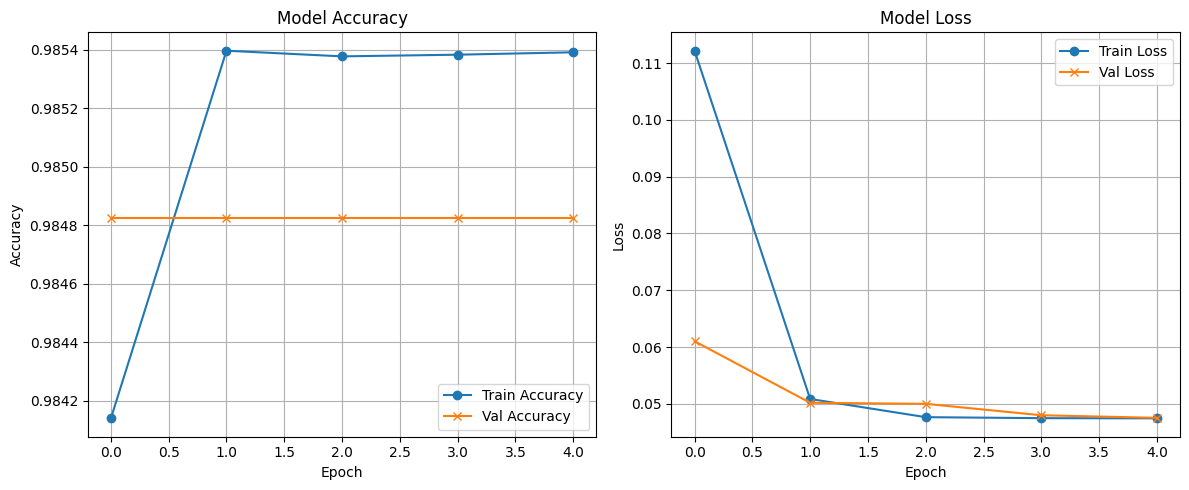

In [13]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()